In [ ]:
import os
import PEC_Parser
import numpy as np

folders = os.listdir('pec_domains')
for folder in folders:
    print(folder)
    domains = os.listdir(f"pec_domains\{folder}")
    for domain in domains:
        print(f"\t{domain}")


abstract_domains
	decay.txt
complex_domains
	cooking_robot.txt
	tamogatchi.txt
	tea_making.txt
	tuberculosis.txt
toy_domains
	bacteria.txt
	coin.txt
	dice_coin.txt
	domain_syntax_template.txt
	stairs.txt


In [213]:
def create_model(domain_string):
    # Instantiate a domain object
    domain = PEC_Parser.domain()

    # Compute fluents, values, states, and actions as dictionaries for domain object
    domain.initialise_all(domain_string)

    state_dict = domain.state_dict
    action_dict = domain.action_dict
    
    initial_distribution = domain.get_initial(domain_string)
    transition_matrix = domain.get_transition(domain_string)
    policy_matrix = domain.get_policy(domain_string)
    n_steps = domain.max_instant
    
    states = list(state_dict.values())
    actions = list(action_dict.values())
    mdp = PEC_Parser.pecmdp(states, actions, transition_matrix, initial_distribution)
    
    return(mdp, policy_matrix, n_steps, domain)   


def sample(model, policy_matrix, n_steps, sample_sizes, num_runs):
    all_samples = []
    for n in sample_sizes:
        print(f"current sample size: {n}")
        sample_answers = []
        for _ in range(num_runs):
            sampled_trajectories = [model.sample_trajectory(n_steps, policy_matrix) for sample in range(n)]
            sample_answers.append(sampled_trajectories)
        all_samples.append(sample_answers)
    return(all_samples)


def estimate(domain, query_time, query_literal, sampled_trajectories):

    states_associated = set(domain.partial_to_states(query_literal))
    sampled_states = [trajectory_[query_time] for trajectory_ in sampled_trajectories if trajectory_[query_time] in states_associated]
        
    answer = len(sampled_states) / len(sampled_trajectories)
    return(answer)

def read_domain(folder, domain):
    file_path = f"pec_domains\{folder}\{domain}"
    file = open(file_path, "r")
    domain_string = file.read()
    return(domain_string)


def analysis_plot(sample_sizes, all_samples, ground_truth, precision):
    # Assuming all_samples[i] contains multiple independent estimates for sample size sample_sizes[i]
    for i in range(len(sample_sizes)):
        # Calculate the proportion of estimates within precision of ground truth
        successes = sum([1 for estimate in all_samples[i] if abs(estimate - ground_truth) <= precision])
        total_trials = len(all_samples[i])
        confidence = successes / total_trials
        confidence_levels.append(confidence)

    plt.plot(sample_sizes, confidence_levels, marker="o")
    for i, (x, y) in enumerate(zip(sample_sizes, confidence_levels)):
        # Offset the annotation slightly above the point
        plt.annotate(x, 
                    xy=(x, y),
                    xytext=(0, -20),  # 10 points vertical offset
                    textcoords='offset points',
                    ha='center',  # Horizontal alignment
                    va='bottom')  # Vertical alignment
    plt.xlabel('Sample Size')
    plt.ylabel('Confidence (Probability |p̂ - p| ≤ ε)')
    plt.axhline(y=0.95, color='r', linestyle='--', label='95% Confidence Target')
    plt.legend()
    plt.title(f'Confidence vs Sample Size (ε = {precision})')
    plt.show()

In [199]:
domain_string_dice = read_domain("toy_domains", "dice_coin.txt")
test_mdp_1, test_policy_1, test_steps_1, test_domain_1 = create_model(domain_string_dice)

In [ ]:
test_samples_1 = sample(test_mdp_1, test_policy_1, test_steps_1, [50, 100, 500, 1000, 2000, 5000], 1000)

current sample size: 50
current sample size: 100
current sample size: 500
current sample size: 1000
current sample size: 2000
current sample size: 5000


In [202]:
domain_string_dice = read_domain("complex_domains", "tamogatchi.txt")
test_mdp_2, test_policy_2, test_steps_2, test_domain_2 = create_model(domain_string_dice)
test_samples_2 = sample(test_mdp_2, test_policy_2, test_steps_2, [50, 100, 500, 1000, 2000, 5000], 1000)

current sample size: 50
current sample size: 100
current sample size: 500
current sample size: 1000
current sample size: 2000
current sample size: 5000


In [214]:
domain_string_tea = read_domain("complex_domains", "tea_making.txt")
print(domain_string_tea)
test_mdp_3, test_policy_3, test_steps_3, test_domain_3 = create_model(domain_string_tea)
test_samples_3 = sample(test_mdp_3, test_policy_3, test_steps_3, [50, 100], 100)

location takes-values {home, shop}
tea_status takes-values {in_cup, in_stock, missing}
cup takes-values {empty, full}
shop takes-values {open, closed}
tea_brewed takes-values {true, false}

initially-one-of {
		( {location=home, tea_status=in_stock, cup=empty, shop=open, tea_brewed=false}, 0.4 ),
		( {location=home, tea_status=missing, cup=empty, shop=open, tea_brewed=false}, 0.15 ),
        ( {location=home, tea_status=missing, cup=empty, shop=closed, tea_brewed=false}, 0.15 ),
        ( {location=shop, tea_status=in_stock, cup=empty, shop=open, tea_brewed=false}, 0.15 ),
        ( {location=shop, tea_status=missing, cup=empty, shop=open, tea_brewed=false}, 0.15 )
	}

{travel=true, location=home} causes-one-of
					{
						( {location=shop}, 1 )
					}

{travel=true, location=shop} causes-one-of
					{
						( {location=home}, 1 )
					}

{buy=true, location=shop, shop=open} causes-one-of
					{
						( {tea_status=in_stock}, 1 )
					}

{pour_water=true} causes-one-of
               

In [224]:
len(test_samples_3[0][0])

50

In [ ]:
estimate(test_domain_3, 6, "tea_brewed=true", test_samples_3[0][])

0.84

In [97]:
folder = "complex_domains"
domain = "cooking_robot.txt"
file_path = f"pec_domains\{folder}\{domain}"
file = open(file_path, "r")
domain_string = file.read()

In [98]:
test_mdp, test_policy, test_steps, test_domain = create_model(domain_string)

In [99]:
test_samples = sample(test_mdp, test_policy, test_steps, [100, 500, 1000, 2000, 5000, 10000], 1000)

current sample size: 100
current sample size: 500
current sample size: 1000
current sample size: 2000
current sample size: 5000
current sample size: 10000


In [170]:
tes = sample(test_mdp, test_policy, test_steps, [50, 100, 500, 1000, 2000, 5000], 1000)

current sample size: 50
current sample size: 100
current sample size: 500
current sample size: 1000
current sample size: 2000
current sample size: 5000


In [191]:
ground_truth = 0.95**6 * (1-0.5**4) * ( 0.05)
query_time = 11
query_literal = "soup=complete"
print(ground_truth)

0.03445743237304687


In [188]:
estimate_container = []
for sample_size in tes:
    sub_estimates = []
    for batch in sample_size:
        estimates = estimate(test_domain, query_time, query_literal, batch)
        sub_estimates.append(estimates)
    estimate_container.append(sub_estimates)

In [167]:
print(estimate_container[0])

[0.76, 0.66, 0.8, 0.8, 0.62, 0.74, 0.56, 0.66, 0.62, 0.68, 0.64, 0.78, 0.58, 0.8, 0.56, 0.72, 0.64, 0.62, 0.76, 0.58, 0.62, 0.68, 0.68, 0.5, 0.66, 0.7, 0.72, 0.6, 0.64, 0.72, 0.68, 0.66, 0.7, 0.58, 0.64, 0.7, 0.62, 0.82, 0.64, 0.74, 0.64, 0.58, 0.64, 0.64, 0.66, 0.66, 0.64, 0.62, 0.72, 0.82, 0.78, 0.66, 0.68, 0.54, 0.8, 0.58, 0.78, 0.68, 0.6, 0.52, 0.54, 0.52, 0.72, 0.6, 0.8, 0.7, 0.5, 0.76, 0.64, 0.66, 0.58, 0.8, 0.78, 0.7, 0.64, 0.6, 0.58, 0.64, 0.72, 0.72, 0.66, 0.7, 0.56, 0.58, 0.64, 0.7, 0.74, 0.68, 0.68, 0.62, 0.66, 0.66, 0.56, 0.7, 0.64, 0.6, 0.72, 0.74, 0.74, 0.7]


In [159]:
len(estimate_container[0])

for i in range(3):
    print([len(f) for f in estimate_container[i]])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


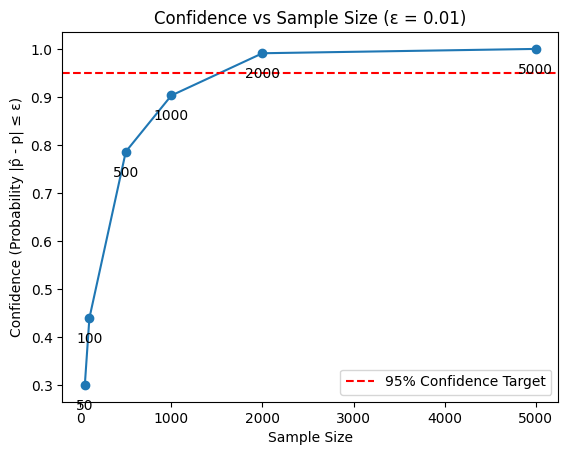

In [193]:
precision = 0.01  # Fixed precision/error threshold
confidence_levels = []
sample_sizes = [100, 500, 1000, 2000, 5000, 10000]

def analysis_plot(sample_sizes, all_samples, ground_truth, precision):
    # Assuming all_samples[i] contains multiple independent estimates for sample size sample_sizes[i]
    for i in range(len(sample_sizes)):
        # Calculate the proportion of estimates within precision of ground truth
        successes = sum([1 for estimate in all_samples[i] if abs(estimate - ground_truth) <= precision])
        total_trials = len(all_samples[i])
        confidence = successes / total_trials
        confidence_levels.append(confidence)

    plt.plot(sample_sizes, confidence_levels, marker="o")
    for i, (x, y) in enumerate(zip(sample_sizes, confidence_levels)):
        # Offset the annotation slightly above the point
        plt.annotate(x, 
                    xy=(x, y),
                    xytext=(0, -20),  # 10 points vertical offset
                    textcoords='offset points',
                    ha='center',  # Horizontal alignment
                    va='bottom')  # Vertical alignment
    plt.xlabel('Sample Size')
    plt.ylabel('Confidence (Probability |p̂ - p| ≤ ε)')
    plt.axhline(y=0.95, color='r', linestyle='--', label='95% Confidence Target')
    plt.legend()
    plt.title(f'Confidence vs Sample Size (ε = {precision})')
    plt.show()
    
analysis_plot([50,100,500,1000, 2000,5000], estimate_container, ground_truth, precision)

In [20]:
initial_distribution = domain.get_initial(domain_string)
transition_matrix = domain.get_transition(domain_string)
policy_matrix = domain.get_policy(domain_string)
n_steps = domain.max_instant

In [21]:
states = list(state_dict.values())
actions = list(action_dict.values())
mdp = PEC_Parser.pecmdp(states, actions, transition_matrix, initial_distribution)

In [32]:
sample_n = 500000
sampled_trajectories = []

for sample_ in range(sample_n):
    trajectory = mdp.sample_trajectory(n_steps, policy_matrix)
    sampled_trajectories.append(trajectory)

In [33]:
trajectory = mdp.sample_trajectory(n_steps, policy_matrix)

print(f"Sampled trajectory: {trajectory}")
print(f"Sampled trajectory: {[domain.translate_int_to_lit(s) for s in trajectory]}")

Sampled trajectory: [1, 1, 0, 0]
Sampled trajectory: ['Coin=Tails', 'Coin=Tails', 'Coin=Heads', 'Coin=Heads']


In [34]:
query_time = 3 # From 0 to max time instant
query_literal = "Coin=Heads"

states_associated = set(domain.partial_to_states(query_literal))
sampled_states = [trajectory_[query_time] for trajectory_ in sampled_trajectories if trajectory_[query_time] in states_associated]
    
answer = len(sampled_states) / sample_n
print(answer)

0.745058


In [ ]:
# Assuming you know the true probability p
true_p = 0.745 # Known analytically or by exhaustive computation

sample_sizes = [100, 500, 1000, 2000, 5000, 10000]  # Different n values to test
num_runs = 1000  # Number of times to repeat the experiment (M)
epsilon = 0.05  # Desired accuracy

results = {}


for n in sample_sizes:
    successes = 0
    
    for _ in range(num_runs):
        # Sample n trajectories
        
        sampled_trajectories = []

        for sample_ in range(n):
            trajectory = mdp.sample_trajectory(n_steps, policy_matrix)
            sampled_trajectories.append(trajectory)
        
        # Calculate estimate using your method
        sampled_states = [trajectory_[query_time] for trajectory_ in sampled_trajectories 
                         if trajectory_[query_time] in states_associated]
        answer = len(sampled_states) / n
        
        # Check if estimate is within epsilon of true_p
        if abs(answer - true_p) <= epsilon:
            successes += 1
    
    # Calculate proportion of successful estimates
    success_rate = successes / num_runs
    results[n] = success_rate


NameError: name 'plt' is not defined

Text(0.5, 1.0, 'PAC Guarantee Verification')

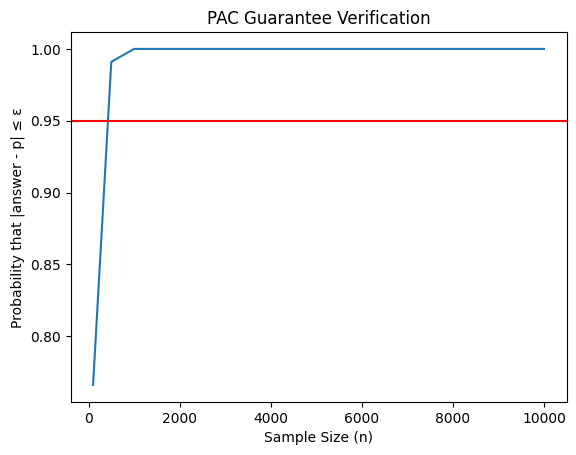

In [40]:
import matplotlib.pyplot as plt
# Plot results
plt.plot(sample_sizes, [results[n] for n in sample_sizes])
plt.axhline(y=0.95, color='r', linestyle='-')  # Line at confidence level
plt.xlabel('Sample Size (n)')
plt.ylabel('Probability that |answer - p| ≤ ε')
plt.title('PAC Guarantee Verification')

In [46]:
sample_sizes = [50, 100, 200, 500, 1000, 2000, 5000, 10000]  # Different n values to test
num_runs = 1000  # Number of times to repeat the experiment (M)
all_samples = []
for n in sample_sizes:
    print(n)
    sample_answers = []
    for _ in range(num_runs):
        # Sample n trajectories
        
        sampled_trajectories = []
        for sample_ in range(n):
            trajectory = mdp.sample_trajectory(n_steps, policy_matrix)
            sampled_trajectories.append(trajectory)
        
        # Calculate estimate using your method
        sampled_states = [trajectory_[query_time] for trajectory_ in sampled_trajectories 
                        if trajectory_[query_time] in states_associated]
        sample_answers.append(len(sampled_states) / n)
    all_samples.append(sample_answers)


50
100
200
500
1000
2000
5000
10000


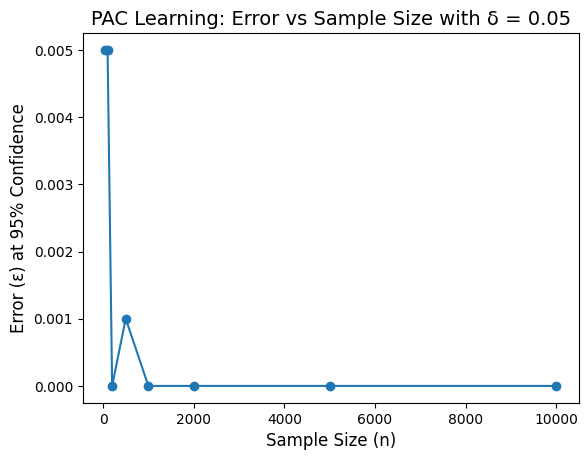

In [91]:
# investigating precision at fixed delta

delta = 0.05
ground_truth = 0.745
error_thresholds = []
for sample_size in all_samples:
    errors = [abs(estimate - ground_truth) for estimate in sample_size]
    error_threshold = sorted(errors)[num_runs*int(1-delta)]
    error_thresholds.append(error_threshold)

plt.plot(sample_sizes, error_thresholds, marker="o")
plt.xlabel('Sample Size (n)', fontsize=12)
plt.ylabel('Error (ε) at 95% Confidence', fontsize=12)
plt.title('PAC Learning: Error vs Sample Size with δ = 0.05', fontsize=14)
plt.show()

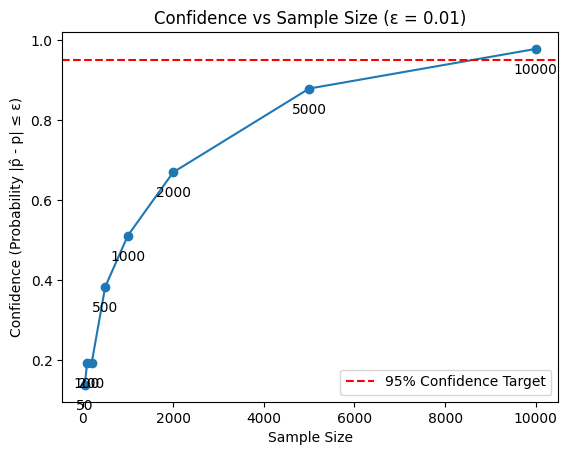

In [183]:
# investigating range of samples at fixed error/precision

precision = 0.01  # Fixed precision/error threshold
ground_truth = 0.745
confidence_levels = []
sample_sizes = [50, 100, 200, 500, 1000, 2000, 5000, 10000]

# Assuming all_samples[i] contains multiple independent estimates for sample size sample_sizes[i]
for i in range(len(sample_sizes)):
    # Calculate the proportion of estimates within precision of ground truth
    successes = sum([1 for estimate in all_samples[i] if abs(estimate - ground_truth) <= precision])
    total_trials = len(all_samples[i])
    confidence = successes / total_trials
    confidence_levels.append(confidence)

plt.plot(sample_sizes, confidence_levels, marker="o")
for i, (x, y) in enumerate(zip(sample_sizes, confidence_levels)):
    # Offset the annotation slightly above the point
    plt.annotate(x, 
                xy=(x, y),
                xytext=(0, -20),  # 10 points vertical offset
                textcoords='offset points',
                ha='center',  # Horizontal alignment
                va='bottom')  # Vertical alignment
plt.xlabel('Sample Size')
plt.ylabel('Confidence (Probability |p̂ - p| ≤ ε)')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Confidence Target')
plt.legend()
plt.title(f'Confidence vs Sample Size (ε = {precision})')
plt.show()

In [17]:
0.5*0.51 + 0.5*0.49*0.49 + 0.5*0.49 + 0.5*0.51*0.49

0.745

In [ ]:

sample_sizes = [50, 100, 200, 500, 1000, 2000, 5000, 10000]  # Different n values to test
num_runs = 1000  # Number of times to repeat the experiment (M)

def sampling(model, sample_sizes, num_runs):
    all_samples = []
    for n in sample_sizes:
        print(n)
        sample_answers = []
        for _ in range(num_runs):
            # Sample n trajectories
            
            sampled_trajectories = []
            for sample_ in range(n):
                trajectory = model.sample_trajectory(n_steps, policy_matrix)
                sampled_trajectories.append(trajectory)
            
            # Calculate estimate using your method
            sampled_states = [trajectory_[query_time] for trajectory_ in sampled_trajectories 
                            if trajectory_[query_time] in states_associated]
            sample_answers.append(len(sampled_states) / n)
        all_samples.append(sample_answers)
    return(all_samples)